In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

ds = xr.open_dataset("surf_data_2020.nc")

In [4]:
def plot_contour_map(snapshot, variable, title_prefix, cmap='Blues', unit_label=''):
    """
    Generates a professional, publication-quality contour map for a given
    variable from a single time-step (snapshot).

    Args:
        snapshot (xarray.Dataset): The data for a single time step.
        variable (str): The short name of the variable to plot (e.g., 'swh', 'sst').
        title_prefix (str): The main title for the plot.
        cmap (str): The matplotlib colormap.
        unit_label (str): The label for the colorbar (e.g., '(m)', '(m/s)').
    """
    
    # Get the specific data array to plot
    data_to_plot = snapshot[variable]
    lons = snapshot.longitude
    lats = snapshot.latitude
    
    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={"projection": ccrs.PlateCarree()})
    
    # Set map extent from the data's boundaries
    ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()], crs=ccrs.PlateCarree())

    # --- Add map features (layered with zorder) ---
    ax.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='#c7b69a')
    ax.add_feature(cfeature.OCEAN, zorder=0, facecolor='#aadaff')
    ax.add_feature(cfeature.COASTLINE, zorder=2)
    ax.add_feature(cfeature.BORDERS, linestyle=':', zorder=2)
    
    # Add gridlines
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,
                      color='gray', linestyle='--', alpha=0.5, zorder=3)
    gl.top_labels = False
    gl.right_labels = False

    # --- Plot the Data ---
    # Define 15 levels for a smooth look, as in your example
    data_min = data_to_plot.min().item()
    data_max = data_to_plot.max().item()
    levels = np.linspace(data_min, data_max, 15)

    # Plot filled contours (the color)
    cs = ax.contourf(lons, lats, data_to_plot,
                    levels=levels, cmap=cmap, 
                    transform=ccrs.PlateCarree(), zorder=1,
                    extend='both') # Add arrows for values outside the range

    # Plot contour lines (the lines)
    contours = ax.contour(lons, lats, data_to_plot,
                          colors='black', linewidths=0.5, alpha=0.7,
                          levels=levels,
                          transform=ccrs.PlateCarree(), zorder=3)
    
    # Add labels to the contour lines
    ax.clabel(contours, inline=True, fontsize=8, fmt="%.1f")

    # --- Add Legend and Title ---
    cbar = plt.colorbar(cs, ax=ax, orientation="vertical", shrink=0.7, pad=0.08)
    cbar.set_label(f"{title_prefix} {unit_label}")

    # Add title with the timestamp
    time_str = str(snapshot.valid_time.values)
    ax.set_title(f"{title_prefix}\n{time_str}", fontsize=16)
    
    plt.show()

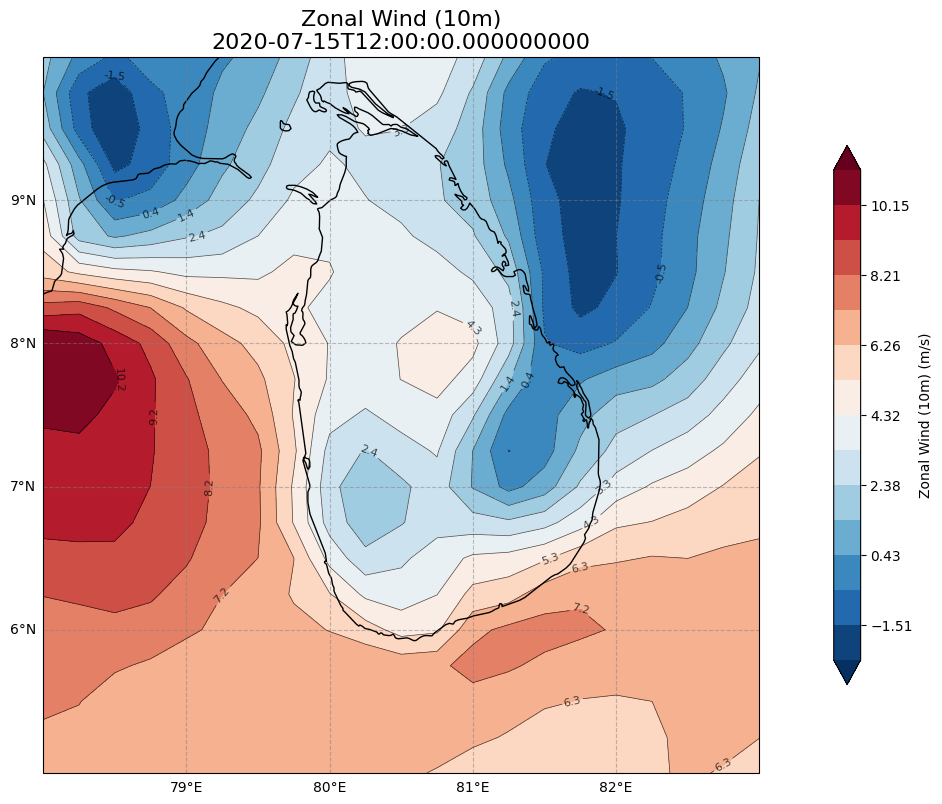

In [6]:
# Select a single time step ---
snapshot = ds.sel(valid_time='2020-07-15T12:00:00')

# Plot the 'u10' (Wind) map ---
plot_contour_map(
    snapshot, 
    variable='u10', 
    title_prefix='Zonal Wind (10m)', 
    cmap='RdBu_r', # Red-Blue colormap for wind
    unit_label='(m/s)'
)

In [3]:
import folium
import folium.plugins
import xarray as xr
import numpy as np

# Load your dataset
ds = xr.open_dataset("surf_data_2020.nc")

In [4]:
target_time = '2020-07-15T12:00:00'

# Define coordinates for a specific surf spot (e.g., Arugam Bay)
spot_lat = 6.84
spot_lon = 81.83

try:
    time = ds.sel(valid_time=target_time)
    print(f"Data selected for {target_time} as {time}")
except KeyError:
    print(f"Error: Time {target_time} not found in dataset. Check your date/time.")

Data selected for 2020-07-15T12:00:00 as <xarray.Dataset> Size: 13kB
Dimensions:     (latitude: 21, longitude: 21)
Coordinates:
    valid_time  datetime64[ns] 8B 2020-07-15T12:00:00
  * latitude    (latitude) float64 168B 5.0 5.25 5.5 5.75 ... 9.25 9.5 9.75 10.0
  * longitude   (longitude) float64 168B 78.0 78.25 78.5 ... 82.5 82.75 83.0
    number      int64 8B ...
    expver      <U4 16B ...
Data variables:
    u10         (latitude, longitude) float32 2kB ...
    v10         (latitude, longitude) float32 2kB ...
    msl         (latitude, longitude) float32 2kB ...
    sst         (latitude, longitude) float32 2kB ...
    tcc         (latitude, longitude) float32 2kB ...
    tp          (latitude, longitude) float32 2kB ...
    swh         (latitude, longitude) float32 2kB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:

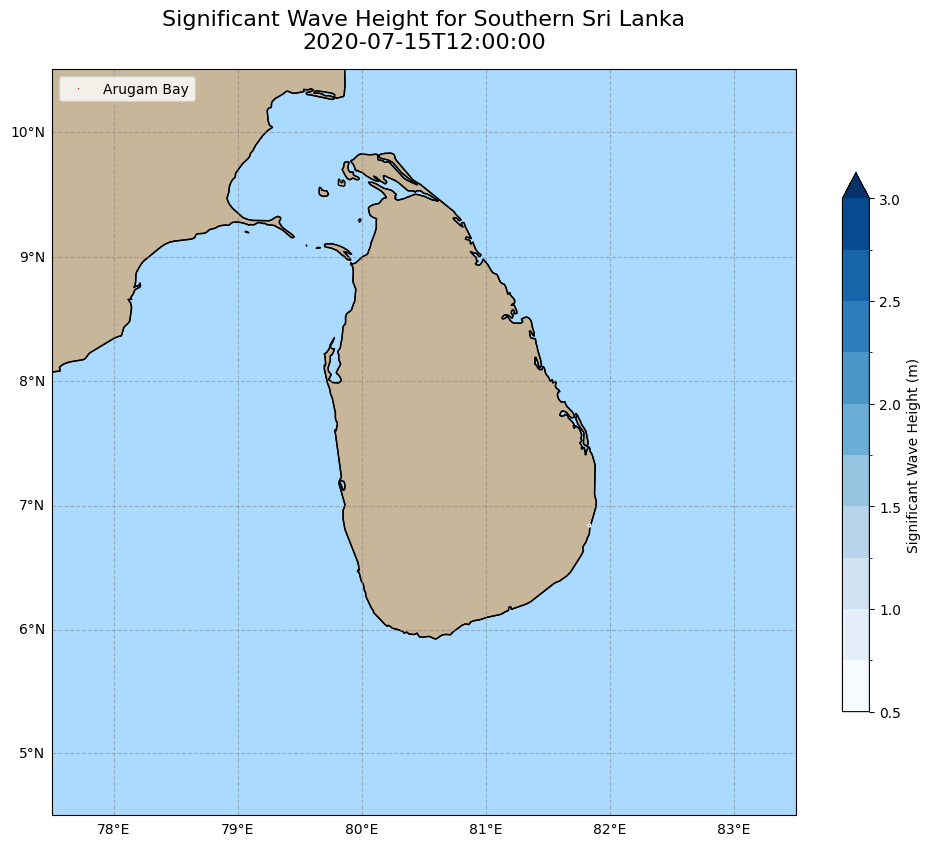

In [5]:
swh_data = time['swh']

plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.Mercator())
buffer = 0.5
ax.set_extent([
    ds.longitude.min() - buffer, ds.longitude.max() + buffer,
    ds.latitude.min() - buffer, ds.latitude.max() + buffer
], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='#c7b69a')
ax.add_feature(cfeature.OCEAN, zorder=0, facecolor='#aadaff')
ax.add_feature(cfeature.COASTLINE, zorder=2)
ax.add_feature(cfeature.BORDERS, linestyle=':', zorder=3)

levels = np.arange(0.5, 3.1, 0.25)
swh_data.plot.contourf(
    ax=ax, transform=ccrs.PlateCarree(), levels=levels,
    cmap='Blues', cbar_kwargs={'label': 'Significant Wave Height (m)', 'shrink': 0.7},
    extend='max', zorder=2
)
swh_data.plot.contour(
    ax=ax, transform=ccrs.PlateCarree(), levels=levels,
    colors='black', linewidths=0.5, zorder=3
)

ax.plot(spot_lon, spot_lat, 'o', color='red', markersize=2, markeredgecolor='white',
        transform=ccrs.PlateCarree(), label='Arugam Bay', zorder=5)
ax.legend(loc='upper left')

gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,
                  color='gray', linestyle='--', alpha=0.5, zorder=4)
gl.top_labels = False
gl.right_labels = False

ax.set_title(f"Significant Wave Height for Southern Sri Lanka\n{target_time}", fontsize=16, pad=15)
plt.show()

In [9]:
# --- 4. Method B: Extract Specific Values for a Surf Spot ---

print(f"\n--- Extracting conditions for Arugam Bay at {target_time} ---")

# Use .sel() again to find the nearest grid point to your spot's coordinates
# 'method="nearest"' is essential
spot_data = single_time_data.sel(latitude=spot_lat, longitude=spot_lon, method='nearest')

# Now extract the plain numbers using .item()
swh_value = spot_data['swh'].item()
u_wind = spot_data['u10'].item()
v_wind = spot_data['v10'].item()

# Calculate wind speed from u/v components
wind_speed_mps = np.sqrt(u_wind**2 + v_wind**2) # meters/second
wind_speed_knots = wind_speed_mps * 1.94384    # Convert to knots

print(f"Significant Wave Height: {swh_value:.2f} m")
print(f"U-Wind Component (u10): {u_wind:.2f} m/s")
print(f"V-Wind Component (v10): {v_wind:.2f} m/s")
print(f"Total Wind Speed: {wind_speed_knots:.2f} knots")
print(f"Sea Surface Temp: {spot_data['sst'].item() - 273.15:.2f} °C") # Convert from Kelvin to Celsius
print(f"Total Precipitation: {spot_data['tp'].item() * 1000:.2f} mm") # Convert from meters to mm
print(f"Mean Sea Level Pressure: {spot_data['msl'].item() / 100:.2f} hPa") # Convert from Pa to hPa


--- Extracting conditions for Arugam Bay at 2020-07-15T12:00:00 ---
Significant Wave Height: 2.01 m
U-Wind Component (u10): 3.76 m/s
V-Wind Component (v10): 8.36 m/s
Total Wind Speed: 17.82 knots
Sea Surface Temp: 29.34 °C
Total Precipitation: 0.00 mm
Mean Sea Level Pressure: 1004.79 hPa


In [ ]:
first_timestep = ds.isel(valid_time=0)
swh_data = first_timestep['swh'] # 'swh' is the short name for significant wave height

plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the wave height data
swh_data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', cbar_kwargs={'label': 'Significant Wave Height (m)'})
    
# Add geographical features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Set plot title with the specific time
time_str = str(first_timestep.valid_time.values)
ax.set_title(f"Significant Wave Height for Southern Sri Lanka\n{time_str}")
    
plt.show()